In [49]:
from sklearn.datasets import make_circles
import numpy as np 

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print(X[:5], y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] [1 1 1 1 0]
[ 0.75424625  0.23148074 -0.75615888 ...  0.65611916  0.58905861
  0.92895754]


In [2]:
import pandas as pd 
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y
                        })
                        
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

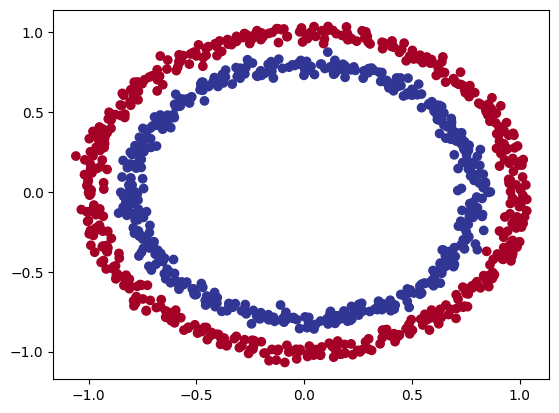

In [11]:
import matplotlib.pyplot as plt 

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);
plt.show();

In [12]:
X.shape, y.shape

((1000, 2), (1000,))

In [13]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_test)

(800, 200)

In [15]:
import torch 
from torch import nn 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
class CircleModel0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModel0().to(device)
model_0

CircleModel0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
# fast_forward computation 

model_0 = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=5),
            nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=5, bias=True)
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
untrained_preds = model_0(X_test.to(device))
print(untrained_preds[:10])

tensor([[ 0.0815],
        [ 0.0853],
        [-0.0493],
        [ 0.1191],
        [-0.2414],
        [-0.2376],
        [-0.0748],
        [-0.1510],
        [-0.0410],
        [ 0.0834]], grad_fn=<SliceBackward0>)


In [31]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [32]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [33]:
y_logits = model_0(X_test.to(device))[:5]
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5204],
        [0.5213],
        [0.4877],
        [0.5297],
        [0.4399]], grad_fn=<SigmoidBackward0>)

In [34]:
y_preds = torch.round(y_pred_probs)

y_preds


tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)

In [35]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69530, Accuracy: 48.62% | Test loss: 0.69780, Test acc: 48.50%
Epoch: 10 | Loss: 0.69457, Accuracy: 49.12% | Test loss: 0.69708, Test acc: 50.50%
Epoch: 20 | Loss: 0.69419, Accuracy: 49.12% | Test loss: 0.69668, Test acc: 49.00%
Epoch: 30 | Loss: 0.69395, Accuracy: 49.88% | Test loss: 0.69642, Test acc: 50.00%
Epoch: 40 | Loss: 0.69378, Accuracy: 50.00% | Test loss: 0.69622, Test acc: 49.00%
Epoch: 50 | Loss: 0.69365, Accuracy: 50.00% | Test loss: 0.69607, Test acc: 48.50%
Epoch: 60 | Loss: 0.69354, Accuracy: 50.38% | Test loss: 0.69594, Test acc: 49.00%
Epoch: 70 | Loss: 0.69346, Accuracy: 50.50% | Test loss: 0.69583, Test acc: 48.50%
Epoch: 80 | Loss: 0.69338, Accuracy: 50.62% | Test loss: 0.69573, Test acc: 47.50%
Epoch: 90 | Loss: 0.69332, Accuracy: 50.25% | Test loss: 0.69565, Test acc: 48.00%


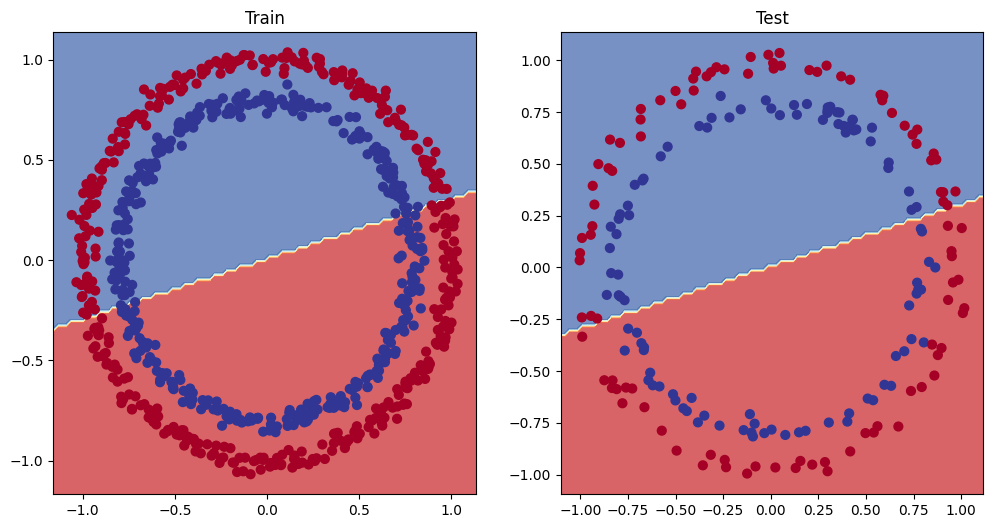

In [36]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)
plt.show()